# Working with Binance API
- https://python-binance.readthedocs.io/en/latest/overview.html

In [1]:
import datetime as dt
import os
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import dateparser

import math
import matplotlib.pyplot as plt

from binance.client import Client

In [2]:
API_PUBLIC = os.environ.get("B_PUBLIC_KEY")
API_SECRET = os.environ.get("B_SECRET_KEY")
client = Client(API_PUBLIC, API_SECRET)

In [3]:
API_PUBLIC

'1NvEsQvukvzuYXF6P75tuymr6LF2E9uWbEa9JTWl08ZrytGNtMSWYpCVmbVviOQ2'

In [4]:
def get_closes(symbol, interval, timedelta, d1=None):
    if d1 is None:
        d1 = dt.datetime.now(dt.timezone.utc)
    assert d1.tzinfo == dt.timezone.utc, "must use utc timezone dates"
    d0 = d1 - timedelta
    start_str = dt.datetime.strftime(d0, "%d-%m-%Y %H:%M:%S")
    (
        t0, o, h, 
        l, c, v, 
        t1, quote_asset_vol, num_trades, 
        tbb_vol, tbq_vol, _
    ) = zip(
        *client.get_historical_klines(
            symbol=symbol, 
            interval=interval, 
            start_str=start_str
        )
    )
    df = pd.DataFrame(
        data=np.array([t0, o, h, l, c, v, t1, quote_asset_vol, num_trades, tbb_vol, tbq_vol]).T, 
        columns=["t0", "o", "h", "l", "c", "v", "t1", "quote_asset_vol", "num_trades", "tbb_vol", "tbq_vol"]
    )
    
    date_cols = ["t0", "t1"]
    float_cols = ["o", "h", "l", "c", "v", "quote_asset_vol", "tbb_vol", "tbq_vol"]
    int_cols = ["num_trades"]
    df["t0"] = df["t0"].apply(dateparser.parse)
    df["t1"] = df["t1"].apply(dateparser.parse)
    
    df[float_cols] = df[float_cols].astype(float)
    df[int_cols] = df[int_cols].astype(int)
    return df[["t1", "c"]]

def get_log_returns(returns):
    return np.log(returns[1:]/returns[:-1])

In [5]:
ltc_sym = "LTCBTC"
eth_sym = "ETHBTC"
interval = Client.KLINE_INTERVAL_5MINUTE
timedelta = dt.timedelta(days=5)
eth_df = get_closes(eth_sym, interval, timedelta)
ltc_df = get_closes(ltc_sym, interval, timedelta)

eth_lr = get_log_returns(eth_df["c"].values)
ltc_lr = get_log_returns(ltc_df["c"].values)
diff = eth_lr - ltc_lr
hedge_ratio = (eth_df["c"]/ltc_df["c"]).values[1:]

data = np.stack([eth_lr, ltc_lr, diff, hedge_ratio]).T
cols = ["eth", "ltc", "diff", "hedge_ratio"]
ix = eth_df["t1"].values[1:]
df = pd.DataFrame(data=data, columns=cols, index=ix)

In [6]:
plt.style.use("fivethirtyeight")

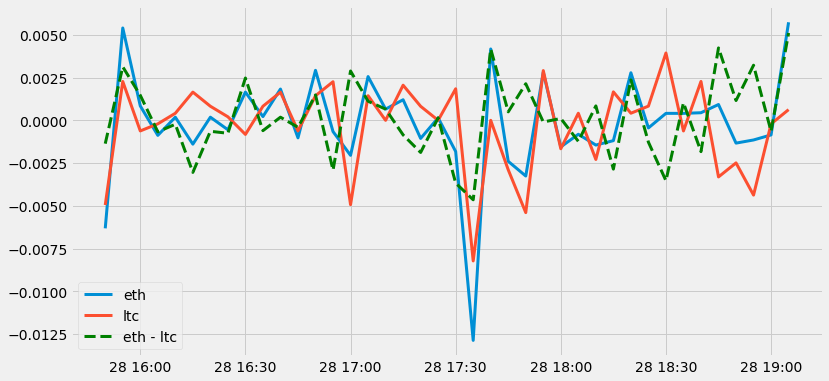

In [7]:
t1 = 10
t2 = 50
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(12,6))
linewidth = 3
alpha = 1
ax1.plot(df.iloc[t1:t2]["eth"],linewidth=linewidth, alpha=alpha, label="eth")
ax1.plot(df.iloc[t1:t2]["ltc"], linewidth=linewidth, alpha=alpha, label="ltc")
ax1.plot(df.iloc[t1:t2]["diff"], "--g", linewidth=linewidth, alpha=alpha, label="eth - ltc")
ax1.legend(loc="best")

# using pytorch forecasting

In [ ]:
# starting with no covariates
zero_data = data

In [ ]:
duration = zero_data.size(-2)

prediction = torch.zeros(zero_data.size(0)).unsqueeze(-1)

init_dist = dist.Normal(0, 10).expand([1]).to_event(1)

time
timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
# Note timescale is a scalar but we need a 1x1 transition matrix (hidden_dim=1),
# thus we unsqueeze twice using [..., None, None].
trans_matrix = torch.exp(-1 / timescale)[..., None, None]
trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)

# Note the obs_matrix has shape hidden_dim x obs_dim = 1 x 1.
obs_matrix = torch.tensor([[1.]])
obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)

noise_dist = dist.GaussianHMM(
    init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)

In [ ]:
prediction.shape

In [ ]:
timesclae

In [ ]:
class Model1(ForecastingModel):
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        
        prediction = torch.zeros(zero_data.size(0)).unsqueeze(-1)

        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)

        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        # Note timescale is a scalar but we need a 1x1 transition matrix (hidden_dim=1),
        # thus we unsqueeze twice using [..., None, None].
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)

        # Note the obs_matrix has shape hidden_dim x obs_dim = 1 x 1.
        obs_matrix = torch.tensor([[1.]])
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)

        noise_dist = dist.GaussianHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)

In [ ]:
data = torch.from_numpy(df["eth"].values).view(-1, 1)
covariates = torch.zeros(data.size(0), 0)
model = Model1()
forecaster = Forecaster(model, data, covariates)

In [ ]:
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))